In [344]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print
    
def init_distributed():

    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    dist_url = "env://" # default
    # only works with torch.distributed.launch // torch.run
    rank = int(os.environ["RANK"])
    world_size = int(os.environ['WORLD_SIZE'])
    local_rank = int(os.environ['LOCAL_RANK'])

    dist.init_process_group(
            backend="nccl",
            init_method=dist_url,
            world_size=world_size,
            rank=rank)

    # this will make all .cuda() calls work properly
    try:
        torch.cuda.set_device(local_rank)
    except:
        print("error at", local_rank)
    # synchronizes all the threads to reach this point before moving on
    dist.barrier()
    setup_for_distributed(rank == 0)

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import copy
import time
import math
import command
import random
import sys
import h5py

#os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'
os.environ['NO_ALBUMENTATIONS_UPDATE'] = '1'

import cv2
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 12, 8

from skimage import img_as_ubyte
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import *
from sklearn.metrics import *

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import segmentation_models_pytorch_3d as smp3d
import timm
from torchtoolbox.tools import mixup_data, mixup_criterion
import torchvision as tv
from torch_ema import ExponentialMovingAverage

from transformers import get_cosine_schedule_with_warmup

import torch.distributed as dist

import logging
logging.getLogger('timm').setLevel(logging.WARNING)

#import redis
#import pickle
#redis_cache = redis.StrictRedis(host='localhost', port=6379, db=0)
#redis_cache.flushdb()

In [345]:
class CFG:
    DDP = 1
    DDP_INIT_DONE = 0
    N_GPUS = 2
    FOLD = 0
    FULLDATA = 0
    
    model_name = -1
    V = -1
    
    OUTPUT_FOLDER = f"./data/segmentation_model/{model_name}_v{V}"
    
    seed = 3407
    
    device = torch.device('cuda')
    
    n_folds = 4
    
    image_size = [256, 256]
    
    train_batch_size = 32
    valid_batch_size = 32
    acc_steps = 1
    
    lr = 1e-3
    wd = 1e-5
    ema_decay_per_epoch = 0.3
    freeze_epochs = 0
    n_epochs = 12
    n_warmup_steps = 0
    upscale_steps = 1.5
    validate_every = 2
    
    epoch = 0
    global_step = 0
    literal_step = 0
    
    autocast = True
    
    workers = 8

if CFG.FULLDATA:
    CFG.seed = CFG.FOLD
    
OUTPUT_FOLDER = CFG.OUTPUT_FOLDER
        
CFG.cache_dir = CFG.OUTPUT_FOLDER + f'/cache/'
os.makedirs(CFG.cache_dir, exist_ok=1)

seed_everything(CFG.seed)

In [346]:
segmentation_folders = np.array([x.split('/')[-1].replace('.nii', '') for x in glob('./data/segmentations/*.nii')])
segmentation_folders.shape, segmentation_folders[:5]

((87,),
 array(['1.2.826.0.1.3680043.30487', '1.2.826.0.1.3680043.24617',
        '1.2.826.0.1.3680043.26498', '1.2.826.0.1.3680043.6376',
        '1.2.826.0.1.3680043.21321'], dtype='<U25'))

In [347]:
revert_list = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

In [348]:
DAT = {'folder_name': [], 'image_path': [], 'mask_path': []}

for folder in segmentation_folders:
    
    image_files = sorted(glob(f'./data/train_images_npy/{folder}/*.npy'), key=lambda x: int(x.split('/')[-1].split('.')[0]))
    mask_files = sorted(glob(f'./data/train_masks_npy/{folder}/*.npy'), key=lambda x: int(x.split('/')[-1].split('.')[0]))
    
    if folder in revert_list:
        mask_files = mask_files[::-1]
    
    DAT['folder_name'].extend([folder]*len(image_files))
    DAT['image_path'].extend(image_files)
    DAT['mask_path'].extend(mask_files)
    
data = pd.DataFrame(DAT)
data

,folder_name,image_path,mask_path
0,1.2.826.0.1.3680043.30487,./data/train_images_npy/1.2.826.0.1.3680043.30...,./data/train_masks_npy/1.2.826.0.1.3680043.304...
1,1.2.826.0.1.3680043.30487,./data/train_images_npy/1.2.826.0.1.3680043.30...,./data/train_masks_npy/1.2.826.0.1.3680043.304...
2,1.2.826.0.1.3680043.30487,./data/train_images_npy/1.2.826.0.1.3680043.30...,./data/train_masks_npy/1.2.826.0.1.3680043.304...
3,1.2.826.0.1.3680043.30487,./data/train_images_npy/1.2.826.0.1.3680043.30...,./data/train_masks_npy/1.2.826.0.1.3680043.304...
4,1.2.826.0.1.3680043.30487,./data/train_images_npy/1.2.826.0.1.3680043.30...,./data/train_masks_npy/1.2.826.0.1.3680043.304...
...,...,...,...
29827,1.2.826.0.1.3680043.3992,./data/train_images_npy/1.2.826.0.1.3680043.39...,./data/train_masks_npy/1.2.826.0.1.3680043.399...
29828,1.2.826.0.1.3680043.3992,./data/train_images_npy/1.2.826.0.1.3680043.39...,./data/train_masks_npy/1.2.826.0.1.3680043.399...
29829,1.2.826.0.1.3680043.3992,./data/train_images_npy/1.2.826.0.1.3680043.39...,./data/train_masks_npy/1.2.826.0.1.3680043.399...
29830,1.2.826.0.1.3680043.3992,./data/train_images_npy/1.2.826.0.1.3680043.39...,./data/train_masks_npy/1.2.826.0.1.3680043.399...


In [349]:
class SpineDataset(Dataset):
    def __init__(self, data, transforms=None, is_training=False):
        self.data = data
        self.transforms = transforms
        self.is_training = is_training
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        row = self.data.iloc[i]
        folder = row.folder_name
        image_path = row.image_path
        mask_path = row.mask_path
        
        image, mask = np.load(image_path), np.load(mask_path)
        
        try:
            row_prev = self.data.iloc[i-2]
            row_next = self.data.iloc[i+2]
        except:
            row_prev = row
            row_next = row
        
        if row_prev.folder_name!=row.folder_name:
            row_prev = row
        if row_next.folder_name!=row.folder_name:
            row_next = row
        
        try: image_prev = np.load(row_prev.image_path)
        except: image_prev = image
        try: image_next = np.load(row_next.image_path)
        except: image_next = image
        
        image = np.stack([image_prev, image, image_next], -1)
        
        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
            if image.dtype==torch.uint8: image = image.float() / image.max()
            
            mask = mask.float().permute(2,0,1)
        
        label = mask.max(-1).values.max(-1).values
        
        return {
            'images': image,
            'masks': mask,
            'labels': label,
            'ids': f"{image_path}"
        }

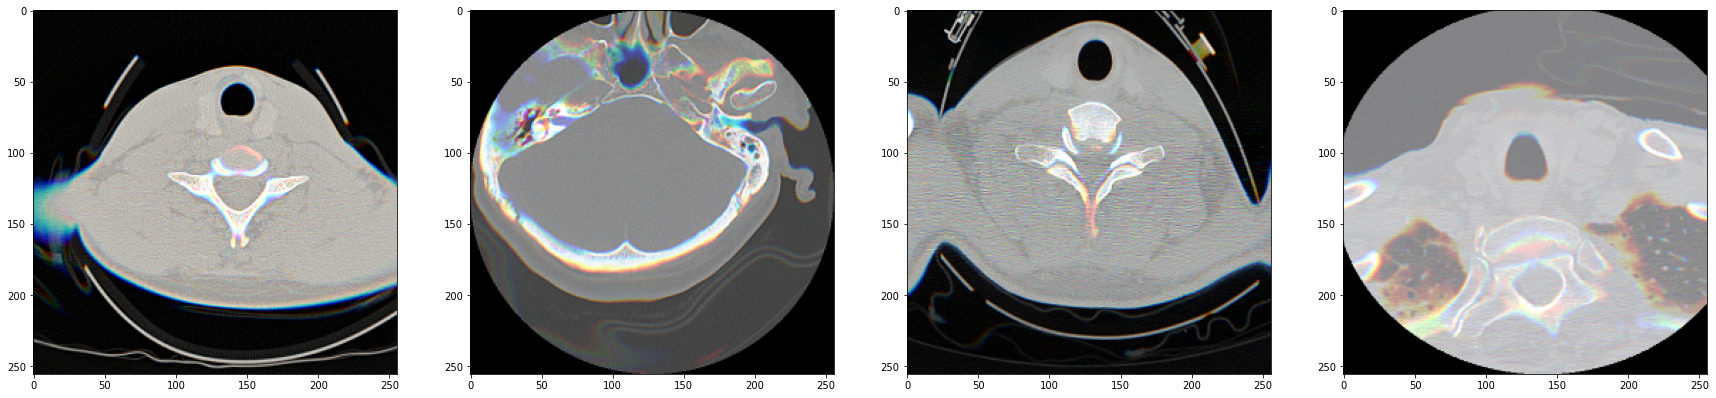

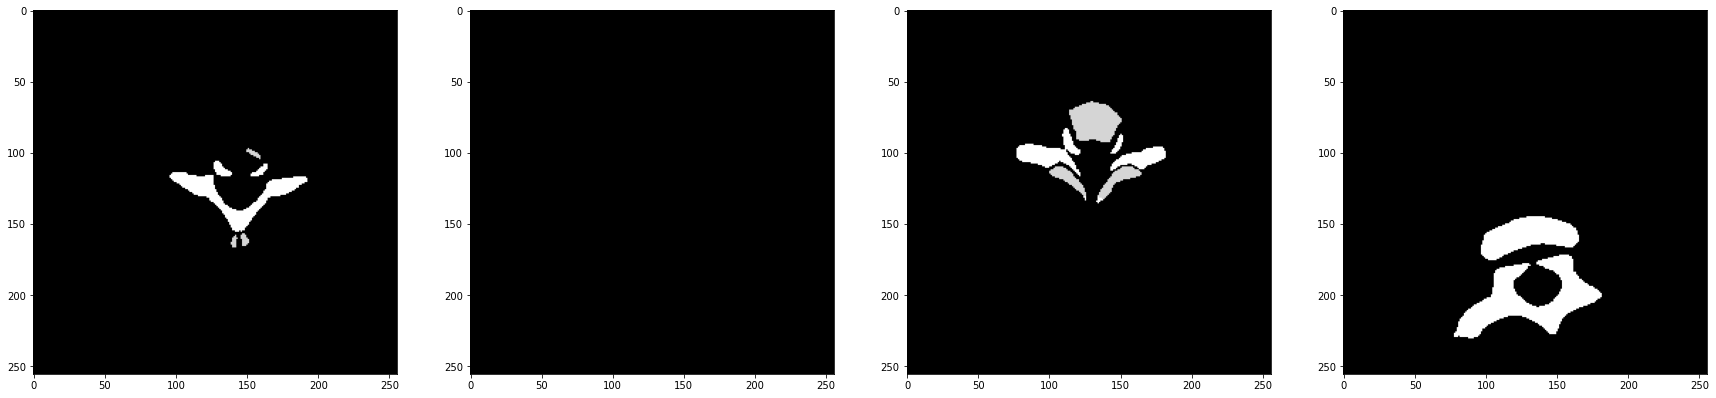

In [352]:
folds = [*GroupKFold(n_splits=CFG.n_folds).split(data, groups=data.folder_name)]

def get_loaders(ret_data=False, n_workers=CFG.workers):
    train_data = data.iloc[folds[CFG.FOLD][0]]
    valid_data = data.iloc[folds[CFG.FOLD][1]]
    
    #valid_data = valid_data[::2]
    
    train_transforms = A.ReplayCompose([
        #A.Resize(*CFG.image_size),
        A.RandomResizedCrop(*CFG.image_size, scale=[0.8, 1.2], ratio=[0.8, 1.2]),
        A.HorizontalFlip(p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        ToTensorV2()
    ])

    valid_transforms = A.ReplayCompose([
        A.Resize(*CFG.image_size),
        ToTensorV2()
    ])
    
    train_dataset = SpineDataset(train_data, train_transforms, 1)
    valid_dataset = SpineDataset(valid_data, valid_transforms, 0)
    
    if CFG.DDP and CFG.DDP_INIT_DONE:
        #train_sampler = torch.utils.data.WeightedRandomSampler(weights_list, len(weights_list)//CFG.N_GPUS)
        
        train_sampler = torch.utils.data.distributed.DistributedSampler(dataset=train_dataset, shuffle=True, drop_last=True)
        train_sampler.set_epoch(CFG.epoch) #needed for shuffling?
        
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, sampler=train_sampler, num_workers=CFG.workers, pin_memory=False, drop_last=True)
        
        valid_sampler = torch.utils.data.distributed.DistributedSampler(dataset=valid_dataset, shuffle=False)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, sampler=valid_sampler, shuffle=False, num_workers=CFG.workers, pin_memory=False)
    else:
        #train_sampler = torch.utils.data.WeightedRandomSampler(weights_list, len(weights_list))
        #train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, sampler=train_sampler, num_workers=CFG.workers, pin_memory=False)
        
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True, num_workers=n_workers, pin_memory=False)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, shuffle=False, num_workers=n_workers, pin_memory=False)
    
    #RUINS VALID-LOADER DDP
    #valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, shuffle=False, num_workers=CFG.workers, pin_memory=False)
    
    CFG.steps_per_epoch = math.ceil(len(train_loader) / CFG.acc_steps)
    
    if ret_data:
        return train_loader, valid_loader, train_data, valid_data
    return train_loader, valid_loader
    
#train_loader, valid_loader = get_loaders(ret_data=False, n_workers=0)
train_loader, valid_loader, train_data, valid_data = get_loaders(ret_data=True, n_workers=0)

#seed_everything(42)

for d in train_loader: break
    
#_, axs = plt.subplots(2, 4, figsize=(24, 12))
_, axs = plt.subplots(1, 4, figsize=(30, 15))
axs = axs.flatten()
for img, ax in zip(range(4), axs):
    try:
        ax.imshow(d['images'][img].numpy().transpose(1,2,0), cmap='gray')
    except: pass

#'''
_, axs = plt.subplots(1, 4, figsize=(30, 15))
axs = axs.flatten()
for img, ax in zip(range(4), axs):
    try:
        ax.imshow(d['masks'][img].numpy().argmax(0), cmap='gray')
    except: pass
#'''

In [331]:
CFG.n_classes = 8
    
class SMPModel(nn.Module):
    def __init__(self, pretrained=True, drop=0.):
        super(Model, self).__init__()
        
        self.segmentor = smp.Unet(encoder_name=f"tu-{CFG.model_name}", encoder_weights='imagenet', in_channels=d['images'].shape[1], classes=CFG.n_classes, aux_params={'classes': CFG.n_classes})
        #self.segmentor = smp.Unet(encoder_name=f"tu-{CFG.model_name}", encoder_weights='imagenet', in_channels=d['images'].shape[1], classes=CFG.n_classes)
        
    def forward(self, inp):
        inp = torch.nan_to_num(inp, 0, 0, 0)
        
        masks, logits = self.segmentor(inp)
        
        logits = torch.nan_to_num(logits, 0, 0, 0)
        masks = torch.nan_to_num(masks, 0, 0, 0)
        
        return logits, masks
    
Model = SMPModel

In [332]:
if CFG.model_name==-1: CFG.model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'

#CFG.model_name = 'maxvit_rmlp_tiny_rw_256.sw_in1k'
#CFG.model_name = 'coat_lite_medium_384.in1k'
#CFG.model_name = 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k'

#'''
model = Model()

model.eval()

#t = time.time()
with torch.no_grad():
    outs = model(d['images'][:1])
#print(time.time() - t)
_ = [print(o.shape) for o in outs if o!=None]

torch.Size([1, 8])
torch.Size([1, 8, 256, 256])


In [333]:
class DiceMetric:
    def __init__(self, num_classes=CFG.n_classes):
        self.num_classes = num_classes
        
        self.intersection = np.zeros(num_classes, dtype=np.float64)
        self.pred_sum = np.zeros(num_classes, dtype=np.float64)
        self.target_sum = np.zeros(num_classes, dtype=np.float64)

    def accumulate(self, outputs: np.ndarray, targets: np.ndarray) -> None:
        rounded_outputs = np.round(outputs)

        batch_size = outputs.shape[0]
        for i in range(batch_size):
            for c in range(self.num_classes):
                pred = rounded_outputs[i, c]
                target = targets[i, c]

                pred_flat = pred.flatten()
                target_flat = target.flatten()

                self.pred_sum[c] += pred_flat.sum()
                self.target_sum[c] += target_flat.sum()
                self.intersection[c] += (pred_flat * target_flat).sum()

    def calculate_score(self):
        class_dice = np.zeros(self.num_classes, dtype=np.float64)
        total_intersection = 0.0
        total_pred_sum = 0.0
        total_target_sum = 0.0

        for c in range(self.num_classes):
            denominator = self.pred_sum[c] + self.target_sum[c]

            if denominator > 0:
                class_dice[c] = 2 * self.intersection[c] / denominator

                total_intersection += self.intersection[c]
                total_pred_sum += self.pred_sum[c]
                total_target_sum += self.target_sum[c]

        overall_denominator = total_pred_sum + total_target_sum
        overall_dice = 2 * total_intersection / overall_denominator if overall_denominator > 0 else 0.0

        return overall_dice, class_dice

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=True)
        
    def forward(self, outputs=None, targets=None, outputs_masks=None, targets_masks=None):
        loss1 = self.dice(outputs_masks, targets_masks)
        loss2 = self.bce(outputs, targets)
        
        loss = loss1 + loss2
        
        return loss

def plot_lr():
    m = nn.Linear(2, 1)
    optimizer = optim.AdamW(m.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_training_steps=CFG.steps_per_epoch * CFG.n_epochs * CFG.upscale_steps, num_warmup_steps=CFG.n_warmup_steps)
    
    lrs = []
    for s in range(int(CFG.n_epochs*CFG.steps_per_epoch*CFG.upscale_steps)):
        lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        lrs.append(lr)
        if s==CFG.n_epochs*CFG.steps_per_epoch:
            break
    return lrs
    
def define_criterion_optimizer_scheduler_scaler(model):
    criterion = CustomLoss().cuda()
    
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    
    ema_decay_per_iter = CFG.ema_decay_per_epoch ** (1 / CFG.steps_per_epoch)
    ema = ExponentialMovingAverage(model.parameters(), decay=ema_decay_per_iter)
    
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_training_steps=CFG.steps_per_epoch * CFG.n_epochs * CFG.upscale_steps, num_warmup_steps=CFG.n_warmup_steps)
    
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.autocast)
    
    return criterion, optimizer, scheduler, scaler, ema

In [321]:
def train_one_epoch(model, loader, running_dist=True):
    model.train()
    running_loss = 0.0

    if is_main_process(): bar = tqdm(loader, bar_format='{n_fmt}/{total_fmt} {elapsed}<{remaining} {postfix}')
    else: bar = loader
    
    for step, data in enumerate(bar):
        step += 1
        
        images = data['images'].cuda()
        targets = data['labels'].cuda()
        targets_masks = data['masks'].cuda()
        
        with torch.cuda.amp.autocast(enabled=CFG.autocast, dtype=torch.float16):
            logits, logits_masks = model(images)
            
            loss = criterion(logits, targets, logits_masks, targets_masks)
        
        running_loss += (loss - running_loss) * (1 / step)
        
        loss = loss / CFG.acc_steps
        scaler.scale(loss).backward()
        
        if step % CFG.acc_steps == 0 or step == len(bar):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            ema.update()
            CFG.global_step += 1
        
        CFG.literal_step += 1
        
        lr = "{:2e}".format(optimizer.param_groups[0]['lr'])
        
        if is_main_process():
            bar.set_postfix(loss=running_loss.item(), lr=float(lr), step=CFG.global_step)
        
        if running_dist:
            dist.barrier()
        
        #if step==4: break
    
    if is_main_process():
        if running_dist:
            torch.save(model.module.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}.pth")
            
        else:
            torch.save(model.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}.pth")
        
        
def valid_one_epoch(path, loader, running_dist=True, debug=False, do_ema=True):
    model.eval()
    model.cuda()
    
    if is_main_process(): bar = tqdm(loader, bar_format='{n_fmt}/{total_fmt} {elapsed}<{remaining} {postfix}')
    else: bar = loader
    
    running_loss = 0.
    DiceScorer = DiceMetric()
    
    OUTPUTS, TARGETS, IDS = [], [], []
    for step, data in enumerate(bar):
        
        with torch.no_grad():
            images = data['images'].cuda()
            targets = data['labels'].cuda()
            targets_masks = data['masks'].cuda()
            ids = data['ids']
            
            with torch.cuda.amp.autocast(enabled=CFG.autocast):
                if do_ema:
                    with ema.average_parameters():
                        logits, logits_mask = model(images)
                else:
                    logits, logits_mask = model(images)
                
            outputs = logits_mask.float().sigmoid().detach().cpu()#.numpy()
            targets = targets_masks.float().detach().cpu()#.numpy()
            
            outputs = nn.functional.interpolate(outputs, (128, 128)).numpy()
            targets = nn.functional.interpolate(targets, (128, 128)).numpy()
            
            #'''
            if running_dist:
                dist.barrier()
                
                np.save(f'{CFG.cache_dir}/preds_{get_rank()}.npy', outputs)
                np.save(f'{CFG.cache_dir}/targets_{get_rank()}.npy', targets)
                np.save(f'{CFG.cache_dir}/ids_{get_rank()}.npy', ids)
                
                dist.barrier()
                
                if is_main_process():
                    outputs = np.concatenate([np.load(f"{CFG.cache_dir}/preds_{_}.npy") for _ in range(CFG.N_GPUS)])
                    targets = np.concatenate([np.load(f"{CFG.cache_dir}/targets_{_}.npy") for _ in range(CFG.N_GPUS)])
                    ids = np.concatenate([np.load(f"{CFG.cache_dir}/ids_{_}.npy") for _ in range(CFG.N_GPUS)])
                    
                dist.barrier()
            else:    
                pass
            
            DiceScorer.accumulate(outputs, targets)
            
            #if step==10: break
            
    if running_dist:
        dist.barrier()
    
    if is_main_process():
        
        score, classwise = DiceScorer.calculate_score()
        
        print(f"EPOCH {CFG.epoch+1} | DICE {score}")
        print(classwise)
    
        return score
    
    if debug:
        return [], [], [], []
    
def run(model, get_loaders):
    if is_main_process():
        epochs = []
        scores = []
    
    best_score = float('-inf')
    for epoch in range(CFG.n_epochs):
        CFG.epoch = epoch
        
        train_loader, valid_loader = get_loaders()
        
        '''
        if CFG.epoch<CFG.freeze_epochs:
            for param in model.module.parameters():
                param.requires_grad = False
        else:
            for param in model.module.parameters():
                param.requires_grad = True
        #'''
        
        train_one_epoch(model, train_loader, running_dist=CFG.DDP_INIT_DONE)
        
        if CFG.DDP_INIT_DONE:
            dist.barrier()
        
        if (CFG.epoch+1)%CFG.validate_every==0 or epoch==0:
            if is_main_process():
                with ema.average_parameters():
                    torch.save(model.module.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}_EMA.pth")
                    
            if CFG.DDP_INIT_DONE:
                dist.barrier()
                
            #score, OUTPUTS, TARGETS, IDS  = valid_one_epoch(f"{OUTPUT_FOLDER}/{CFG.FOLD}_EMA.pth", valid_loader, debug=True, running_dist=CFG.DDP_INIT_DONE)
            score = valid_one_epoch(f"{OUTPUT_FOLDER}/{CFG.FOLD}_EMA.pth", valid_loader, debug=False, running_dist=CFG.DDP_INIT_DONE)
            
        if CFG.DDP_INIT_DONE:
            dist.barrier()
        
        if is_main_process():
            epochs.append(epoch)
            scores.append(score)
            
            if score > best_score:
                print("SAVING BEST!")
                if CFG.DDP_INIT_DONE:
                    with ema.average_parameters():
                        torch.save(model.module.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}_best.pth")
                else:
                    with ema.average_parameters():
                        torch.save(model.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}_best.pth")
                    
                best_score = score
                
                #np.save(f"{OUTPUT_FOLDER}/OUTPUTS_{CFG.FOLD}.npy", OUTPUTS)
                #np.save(f"{OUTPUT_FOLDER}/TARGETS_{CFG.FOLD}.npy", TARGETS)
                #np.save(f"{OUTPUT_FOLDER}/IDS_{CFG.FOLD}.npy", IDS)                
            
            try:
                command.run(['rm', '-r', CFG.cache_dir])
                pass
            except:
                pass
            
            os.makedirs(CFG.cache_dir, exist_ok=1)

In [ ]:
CFG.DDP = 1

if __name__ == '__main__' and CFG.DDP:
    
    world_size = init_distributed()
    CFG.DDP_INIT_DONE = 1
    
    #important to setup before defining scheduler to establish the correct number of steps per epoch
    train_loader, valid_loader = get_loaders()
    
    model = Model().cuda()
    
    #st = torch.load(f'./data/segmentation_model/tf_efficientnetv2_s.in21k_ft_in1k_v5/{CFG.FOLD}_best.pth')
    #for key in ['head.weight', 'head.bias']: del st[key]
    #model.load_state_dict(st, strict=False)
    
    #if is_main_process():
        #torch.save(model.state_dict(), f"{OUTPUT_FOLDER}/{CFG.FOLD}.pth")
        
    #model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
    
    local_rank = int(os.environ['LOCAL_RANK'])
    
    model = nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], find_unused_parameters=True)
    
    #model = torch.compile(model)
    
    criterion, optimizer, scheduler, scaler, ema = define_criterion_optimizer_scheduler_scaler(model)
    
    run(model, get_loaders)
    
else:
    
    CFG.DDP_INIT_DONE = False
    #important to setup before defining scheduler to establish the correct number of steps per epoch
    train_loader, valid_loader = get_loaders()
    
    model = Model().cuda()
    
    #model.load_state_dict(torch.load(f"/mnt/md0/rsna_spine/AAA_CLS/TRY12_CLS/b5_v1/best_f{CFG.FOLD}.pth", map_location='cpu'), strict=False)
    
    criterion, optimizer, scheduler, scaler = define_criterion_optimizer_scheduler_scaler(model)
    
    run(model, get_loaders)
    
dist.destroy_process_group()
    
import sys
sys.exit(0)

In [ ]:
model = Model()
st = torch.load('./data/segmentation_model/tf_efficientnetv2_s.in21k_ft_in1k_v2/0_best.pth')
model.load_state_dict(st)

In [241]:
score, OUTPUTS, TARGETS, IDS = valid_one_epoch('', valid_loader, running_dist=False, do_ema=False, debug=True)

230/230 00:48<00:00 

EPOCH 1 | DICE 0.8884672734000317
[0.92898219 0.93450072 0.89479738 0.79354882 0.77353593 0.84226144
 0.90069327 0.9152345 ]


In [201]:
dice_metric = DiceMetric()
#for i in tqdm(range(len(OUTPUTS))):
for i in tqdm(range(0, len(OUTPUTS))):
    outputs = np.array(OUTPUTS[i:i+1])
    targets = np.array(TARGETS[i:i+1])
    dice_metric.accumulate(outputs, targets)
dice_metric.calculate_score()

100%|██████████| 7344/7344 [00:01<00:00, 4034.54it/s]


(0.8285887986191115,
 array([0.88711431, 0.89498578, 0.79986977, 0.69612785, 0.70397728,
        0.76048134, 0.83685777, 0.86644128]))

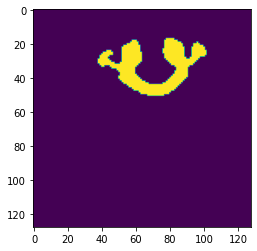

In [87]:
plt.imshow(pred[0] > 0.5)

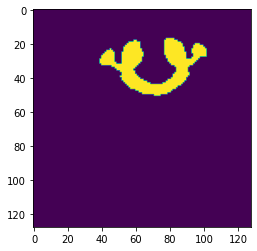

In [72]:
plt.imshow(target[0])

In [142]:
_ = valid_one_epoch('', valid_loader, running_dist=False, do_ema=False)

10/115 00:16<02:49 

EPOCH 1 | DICE 0.3620563409761993
[0.2606436  0.41897539 0.41341498 0.479582   0.3145352  0.36323602
 0.27636935 0.36969418]


In [132]:
np.concatenate(outputs.transpose(0, 4, 1, 2, 3), 0).shape

(128, 8, 256, 256)

In [127]:
outputs.shape, targets.shape

((4, 8, 256, 256, 32), (4, 8, 256, 256, 32))

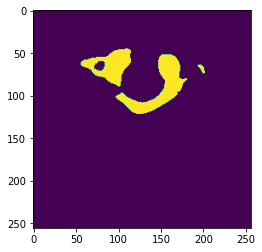

In [116]:
plt.imshow(targets[3][0][:, :, 31])

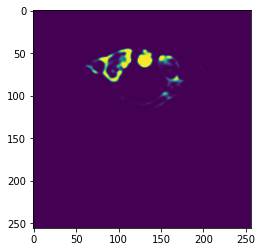

In [115]:
plt.imshow(outputs[3][0][:, :, 31])

In [21]:
def test_one_epoch(path, loader, running_dist=True, debug=False, do_ema=True):
    model = Model(pretrained=False)
    st = torch.load(path, map_location=f"cpu")
    model.eval()
    model.cuda()
    model.load_state_dict(st, strict=False)
    
    if is_main_process(): bar = tqdm(loader, bar_format='{n_fmt}/{total_fmt} {elapsed}<{remaining} {postfix}')
    else: bar = loader
    
    running_loss = 0.
    
    OUTPUTS, TARGETS, IDS = [], [], []
    
    for step, data in enumerate(bar):
        
        with torch.no_grad():
            images = data['images'].cuda()
            targets = data['labels'].cuda()
            #targets_masks = data['masks'].cuda()
            ids = data['ids']
            
            with torch.cuda.amp.autocast(enabled=CFG.autocast):
                if do_ema:
                    with ema.average_parameters():
                        logits, logits_mask = model(images)
                else:
                    logits, logits_mask = model(images)
                
            return logits, logits_mask
                
            outputs = logits.float().detach().cpu().numpy()
            targets = targets.float().detach().cpu().numpy()
            #outputs = logits_mask.float().sigmoid().detach().cpu()#.numpy()
            #targets = targets_masks.float().detach().cpu()#.numpy()
            
            #'''
            if running_dist:
                dist.barrier()
                
                np.save(f'{CFG.cache_dir}/preds_{get_rank()}.npy', outputs)
                np.save(f'{CFG.cache_dir}/targets_{get_rank()}.npy', targets)
                np.save(f'{CFG.cache_dir}/ids_{get_rank()}.npy', ids)
                
                dist.barrier()
                
                if is_main_process():
                    outputs = np.concatenate([np.load(f"{CFG.cache_dir}/preds_{_}.npy") for _ in range(CFG.N_GPUS)])
                    targets = np.concatenate([np.load(f"{CFG.cache_dir}/targets_{_}.npy") for _ in range(CFG.N_GPUS)])
                    ids = np.concatenate([np.load(f"{CFG.cache_dir}/ids_{_}.npy") for _ in range(CFG.N_GPUS)])
                    
                dist.barrier()
            else:    
                pass
            
            OUTPUTS.extend(outputs)
            TARGETS.extend(targets)
            IDS.extend(ids)
            #'''
            
            #if step==10: break
            
    if running_dist:
        dist.barrier()
    
    if is_main_process():
        OUTPUTS = np.stack(OUTPUTS)#[:, :6]
        TARGETS = np.stack(TARGETS)#[:, :6]
        IDS = np.stack(IDS)
        
        #return OUTPUTS, TARGETS, IDS
        
        score = np.mean(np.abs(OUTPUTS-TARGETS))
        
        print(f"EPOCH {CFG.epoch+1} | MAE {score}")
    
        if debug:
            return score, OUTPUTS, TARGETS, IDS
    
        return score
    
    if debug:
        return [], [], [], []

In [39]:
logits, logits_mask = test_one_epoch('./data/AAA_SEG/TRY1_SEG/tf_efficientnetv2_s.in21k_ft_in1k_v2/3_best.pth', valid_loader, do_ema=False, debug=True, running_dist=False)

0/104 00:00<? 


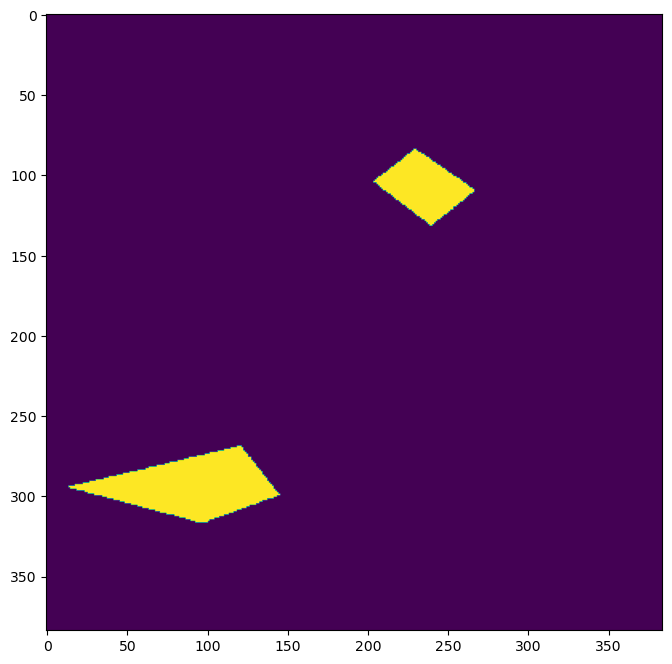

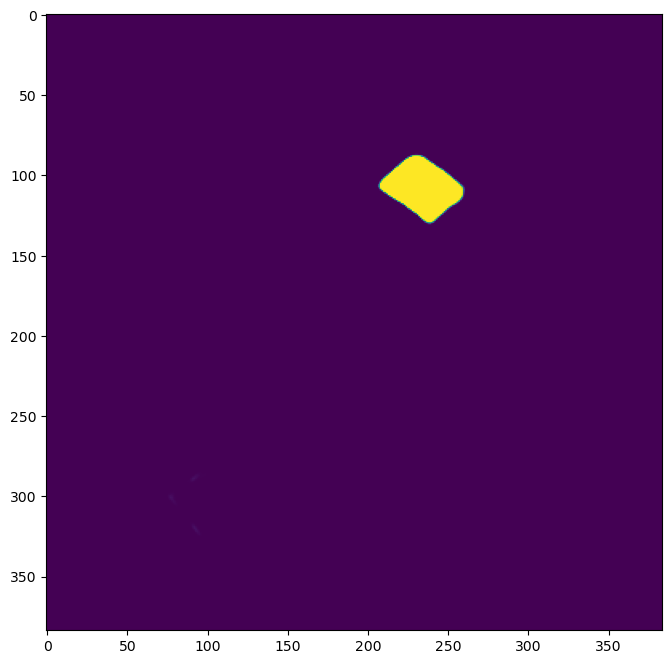

In [46]:
x = 5
plt.imshow(d['masks'][x][1]); plt.show()
plt.imshow(logits_mask.sigmoid()[x][1].detach().cpu()); plt.show()

In [22]:
score, OUTPUTS, TARGETS, IDS = test_one_epoch('./data/AAA_SEG/TRY1_SEG/tf_efficientnetv2_s.in21k_ft_in1k_v1/0_best.pth', valid_loader, do_ema=False, debug=True, running_dist=False)

0/104 00:00<? 


ValueError: not enough values to unpack (expected 4, got 2)

In [100]:
np.abs(np.round(OUTPUTS[:, 0]) - TARGETS[:, 0]).mean()

0.17028986

In [99]:
np.abs(np.round(OUTPUTS[:, 1]) - TARGETS[:, 1]).mean()

3.607488

In [104]:
np.abs(TARGETS[:, 0].mean() - TARGETS[:, 0]).mean()

0.42340544

In [105]:
np.abs(TARGETS[:, 1].mean() - TARGETS[:, 1]).mean()

6.549333

In [95]:
np.round(OUTPUTS[:, 1], 0)

array([ 1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  2.,  4.,  0.,  1.,  2.,
        1.,  2.,  1.,  1.,  2.,  2.,  0.,  4.,  1.,  7.,  3.,  1.,  2.,
        3.,  1.,  1.,  2.,  0.,  4.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,
        0.,  1.,  1.,  2.,  1.,  0.,  2.,  3.,  1.,  2.,  3.,  1.,  2.,
        1.,  2.,  1.,  1.,  1.,  1.,  2.,  1., 11.,  1.,  1.,  1.,  2.,
        1.,  1.,  3.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  3.,  1.,  1.,
        1.,  1.,  0.,  6.,  1.,  1.,  0.,  3.,  1.,  1., 48.,  1.,  0.,
        1.,  1.,  0.,  1.,  3.,  2.,  1.,  2.,  7.,  1.,  2.,  2.,  1.,
        1.,  0.,  1.,  3.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,
        5.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  2.,  2.,  0.,
        2.,  2.,  1.,  4.,  2.,  1.,  1.,  2.,  1.,  0.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  1.,  3.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,
        5.,  8.,  3.,  1.,  6.,  4.,  0.,  1.,  1.,  3.,  2.,  2.,  2.,
        1.,  1.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  5.,  1.,  0

In [93]:
TARGETS[:, 1]

array([  2.,   1.,   1.,   5.,   1.,   2.,   1.,   1.,   2.,   1., 174.,
         1.,   2.,   1.,   2.,   1.,   3.,   2.,   1.,   0.,   2.,   1.,
        14.,   6.,   2.,   1.,   4.,   1.,   1.,   2.,   0.,   4.,   0.,
         1.,   2.,   2.,   2.,   4.,   2.,   0.,   1.,   1.,   3.,   6.,
         0.,   4.,   4.,   1.,   1.,   5.,   1.,   3.,   2.,   2.,   1.,
         2.,   1.,   1.,   1.,   2.,  18.,   1.,   1.,   1.,   3.,   2.,
         2.,   5.,   1.,   2.,   1.,   2.,   1.,   2.,   1.,  18.,   1.,
         1.,   1.,   2.,   0.,  12.,   2.,   1.,   0.,  13.,   1.,   1.,
       171.,   1.,   6.,   2.,   1.,   0.,   1.,   5.,   2.,   2.,   2.,
        17.,   4.,  32.,   3.,   1.,   2.,   0.,   2.,   6.,   1.,   2.,
         2.,   5.,   2.,   0.,   1.,   0.,   3.,   7.,   8.,   1.,   3.,
         2.,   5.,   1.,   3.,   1.,   0.,   4.,   2.,   4.,   2.,   2.,
         2.,   4.,   3.,   1.,   1.,   2.,   1.,   0.,   1.,   1.,   1.,
         7.,   1.,  10.,   0.,   3.,   5.,   1.,   

In [82]:
TARGETS[:, 1].mean()

5.5519323

In [20]:
score, OUTPUTS, TARGETS, IDS = test_one_epoch('./data/AAA_CLS/TRY1_CLS/tf_efficientnetv2_s.in21k_ft_in1k_v2/0_best.pth', valid_loader, do_ema=False, debug=True, running_dist=False)

86/86 00:04<00:00 

EPOCH 1 | AUC 0.9988291900561347


In [26]:
OUTPUTS[TARGETS==0]

array([5.40763059e-11, 2.59097945e-03, 2.60703091e-05, 7.42638076e-05,
       5.29661384e-06, 1.83428929e-05, 2.47727172e-07, 1.78131129e-04,
       9.61024198e-05, 3.87476146e-04, 9.62564215e-08, 2.04203320e-06,
       2.79693013e-05, 2.25558182e-07, 1.30329747e-04, 7.62598110e-11,
       8.53032088e-06, 1.34404097e-08, 6.47594788e-07, 2.62747726e-05,
       9.62212624e-04, 4.57539136e-05, 1.35743306e-07, 9.11051175e-04,
       1.47924666e-07, 1.27787280e-06, 5.91419979e-13, 6.24093036e-06,
       2.21256687e-05, 6.21478264e-08, 9.06971912e-14, 1.21130643e-03,
       1.66139065e-03, 4.13353991e-05, 3.07743088e-04, 1.05432015e-12,
       2.52682275e-05, 4.40011863e-05, 9.02803804e-05, 6.25371322e-05,
       1.81408182e-01, 1.67014205e-05, 3.33656307e-14, 9.57675397e-01,
       2.78030959e-04, 5.44213282e-04, 1.79179879e-05, 1.08451673e-06,
       4.03779013e-05, 7.06640072e-03, 1.47389828e-05, 6.64104824e-04,
       1.92602864e-04, 9.18485270e-08, 8.99096108e-07, 1.32381858e-04,
      

In [25]:
np.sum(TARGETS==0, 0)

array([186, 285, 515])

In [37]:
TARGETS[(TARGETS[:, 0]==0) & (TARGETS[:, 2]!=1.)]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [35]:
TARGETS[(TARGETS[:, 1]==0) & (TARGETS[:, 2]!=1.)]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [42]:
np.round(OUTPUTS[(TARGETS[:, 0]==0) & (TARGETS[:, 2]!=1.)], 3)

array([[0.958, 1.   , 0.   ],
       [0.925, 0.997, 0.001],
       [0.702, 0.999, 0.005],
       [0.892, 0.998, 0.003],
       [0.921, 0.995, 0.002],
       [0.85 , 1.   , 0.001],
       [0.923, 0.999, 0.001],
       [0.944, 1.   , 0.   ],
       [0.922, 1.   , 0.   ],
       [0.954, 1.   , 0.   ],
       [0.891, 1.   , 0.002],
       [0.868, 1.   , 0.001],
       [0.899, 0.942, 0.009],
       [1.   , 0.999, 0.   ]], dtype=float32)

In [58]:
np.round(OUTPUTS[(TARGETS[:, 1]==0) & (TARGETS[:, 2]!=1.)], 3)

array([[1.   , 0.   , 0.   ],
       [1.   , 0.181, 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.992, 0.286, 0.001],
       [0.998, 0.239, 0.   ],
       [0.981, 0.6  , 0.002],
       [0.992, 0.229, 0.001],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.995, 0.161, 0.001],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.001, 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.999, 0.168, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.

In [21]:
OUTPUTS[TARGETS==1]

array([0.9999733 , 1.        , 0.7049733 , ..., 0.9999286 , 0.99997854,
       0.9999826 ], dtype=float32)